In [2]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)
from matplotlib.ticker import AutoMinorLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr


In [1]:
cluster_variables = ['abs_vo600', 'abs_vo850', 'mpi', 'msl', 'r400', 'r600', 'r700', 'r850', 'ssta20', 'ssta30', 'sst', 'vo600', 'vo850', 'vws600-250', 'vws850-200', 'vws_u600-250', 'vws_u850-200', 'vws_v600-250', 'vws_v850-200', 'mgu850', 'mgu600', 'mgv850', 'mgv600', 'zgu850', 'zgu600', 'zgv850', 'zgc600', 'w']
len(cluster_variables)

28

In [3]:
# Create and plot board to visualize which predictors are selected in the best solution and which time lags
def create_board(n_rows, n_cols, final_sequence, sequence_length, feat_sel):
    board = np.zeros((n_rows, n_cols))

    for i in range(n_cols):
        start_index = int(final_sequence[i]) 
        end_index = int(final_sequence[i])  + int(sequence_length[i])
        if feat_sel[i] != 0:
            board[start_index:end_index, i] = 1
    
    return board

def plot_board(board, column_names, feat_sel):
    fig, ax = plt.subplots(figsize=(15, 14))
    ax.imshow(board, cmap='Blues', origin='lower', aspect='auto')
    ax.set_xticks(np.arange(len(column_names)))
    ax.set_xticklabels(column_names, rotation=90, fontsize=11)
    ax.set_yticks(np.arange(board.shape[0])-0.5)
    ax.set_yticklabels(np.arange(board.shape[0]), fontsize=11)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    ax.xaxis.grid(which='minor',color='black', linewidth=1)
    ax.yaxis.grid(which='minor',color='black', linewidth=1)
    ax.set_ylabel('Time lags', fontsize=15)

    for i in range(board.shape[1]):
        if feat_sel[i] == 0:
            rect = plt.Rectangle((i - 0.5, -0.5), 1, 1, color='red')
            ax.add_patch(rect)

    plt.tight_layout()
    return fig

In [4]:
n_clusters = 6
n_vars = 14
n_idxs = 10
results_folder = f'test_nc{n_clusters}_nv{n_vars}_nd{n_idxs}'
basin = 'GLB'
model_kind = 'LinReg'
n_folds = 5
start_year = 1980
end_year = 2021

# Set project directory and name of file containing the target variable
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1965-2022_2.5x2.5.csv'

# Set the paths to the files
experiment_filename = f'1965-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
sol_filename = f'{model_kind}_' + experiment_filename
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'FS_TCG')
output_dir = os.path.join(fs_dir, 'results', results_folder)
sol_path = os.path.join(output_dir, sol_filename)
# final_sol_path = os.path.join(output_dir, f'CRO_{sol_filename}')
data_dir = os.path.join(fs_dir, 'data', f'{basin}_{n_clusters}clusters')
predictors_path = os.path.join(data_dir, predictor_file)
target_path = os.path.join(data_dir, target_file)
results_figure_dir = os.path.join(output_dir, 'figures')
os.makedirs(results_figure_dir, exist_ok=True)

# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)

# Load the labels files and plot the clusters for each atmospheric variable
files_labels = os.listdir(data_dir)
files_labels = [file for file in files_labels if file.startswith('label')]
files_labels.sort()

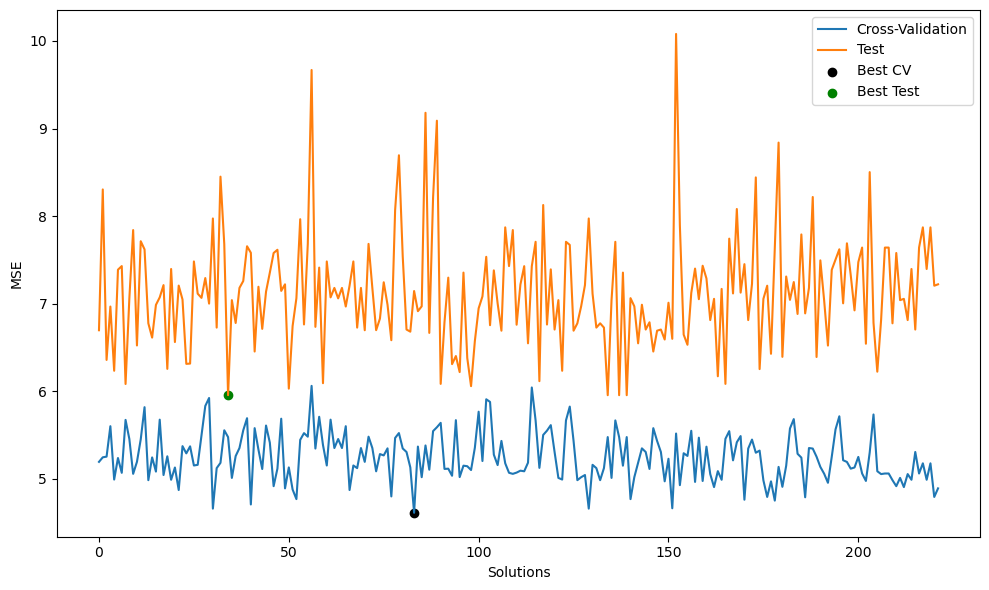

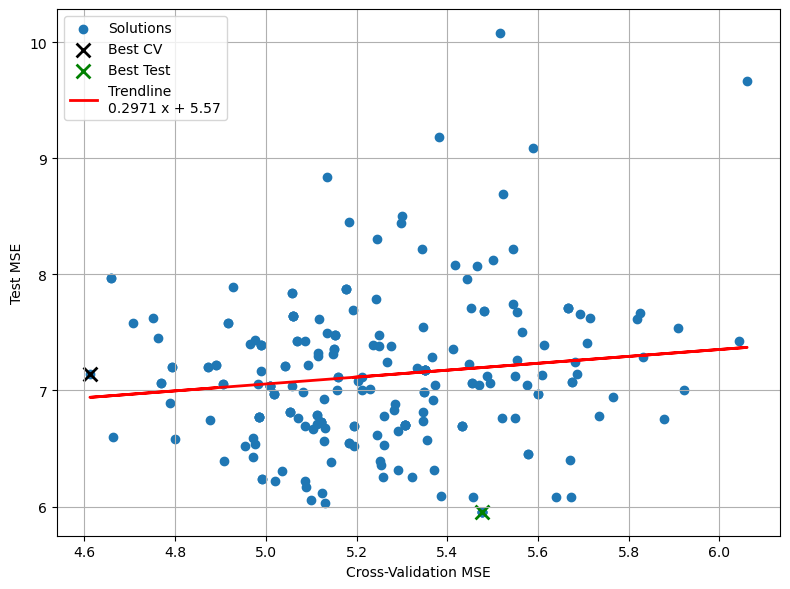

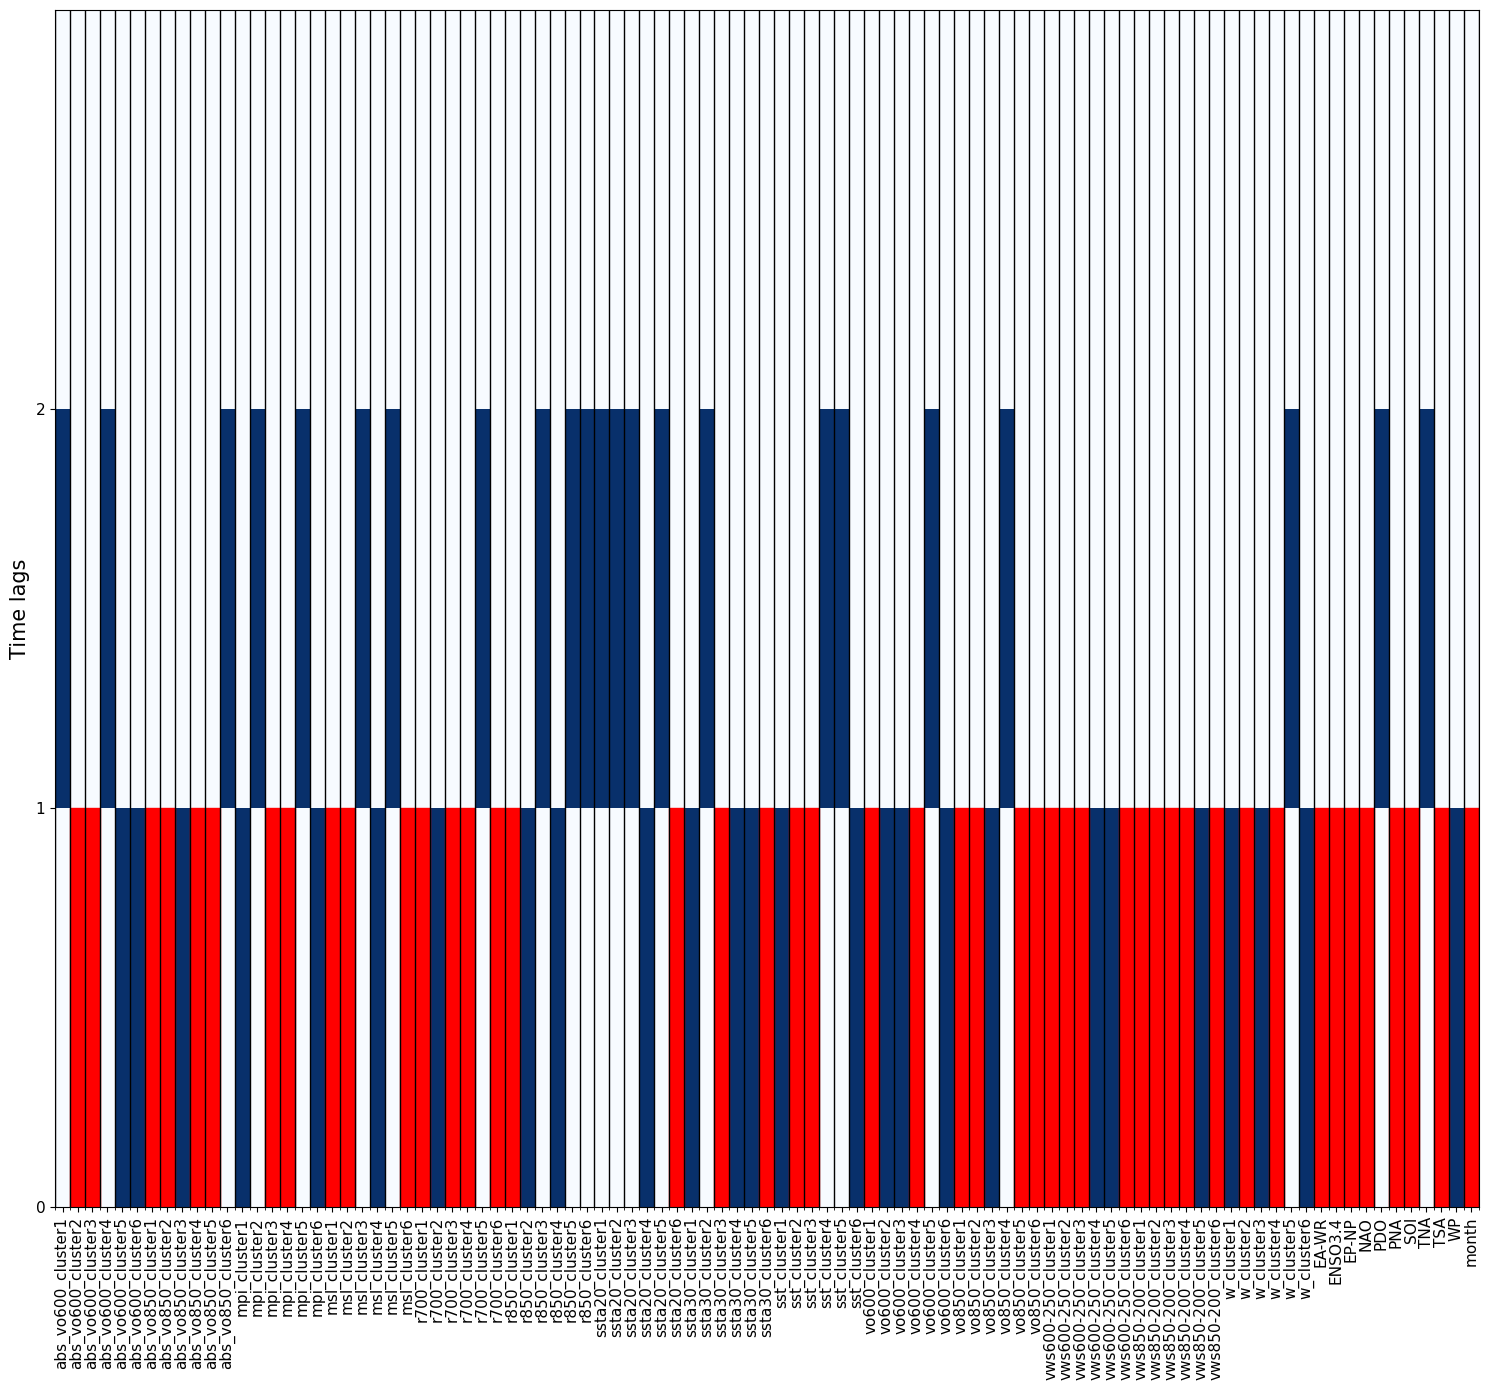

In [5]:
# Load the solutione file in a DataFrame
sol_file_df = pd.read_csv(sol_path, sep=' ', header=0)

# Find solutions with best performance both for Cross-Validation and Test metric
CVbest = sol_file_df['CV'].idxmin() # metric is mean squared error
Testbest = sol_file_df['Test'].idxmin()
array_bestCV = np.fromstring(sol_file_df['Sol'][CVbest].replace('[', '').replace(']', '').replace('\n', ''), dtype=float, sep=' ')
array_bestTest = np.fromstring(sol_file_df['Sol'][Testbest].replace('[', '').replace(']', '').replace('\n', ''), dtype=float, sep=' ')

# Plot the evolution of the metric for each solution found per evaluation
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sol_file_df.index, sol_file_df['CV'], label='Cross-Validation')
ax.plot(sol_file_df.index, sol_file_df['Test'], label='Test')
ax.scatter(sol_file_df.index[CVbest], sol_file_df['CV'][CVbest], color='black', label='Best CV')
ax.scatter(sol_file_df.index[Testbest], sol_file_df['Test'][Testbest], color='green', label='Best Test')
ax.legend()
ax.set_xlabel('Solutions')
ax.set_ylabel('MSE')
plt.tight_layout()

# Scatter plot of Cross-Validation and Test metric for the solutions found, highlightig the 2 bests, also adding the trendline
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(sol_file_df['CV'], sol_file_df['Test'], label='Solutions')
ax.scatter(sol_file_df['CV'][CVbest], sol_file_df['Test'][CVbest], color='black', marker='x', s=100, linewidths=2, label='Best CV')
ax.scatter(sol_file_df['CV'][Testbest], sol_file_df['Test'][Testbest], color='green', marker='x', s=100, linewidths=2, label='Best Test')
z = np.polyfit(sol_file_df['CV'], sol_file_df['Test'], 1)
p = np.poly1d(z)
ax.plot(sol_file_df['CV'], p(sol_file_df['CV']), 'r', label=f'Trendline {p}', linewidth=2)
ax.legend()
ax.grid()
ax.set_xlabel('Cross-Validation MSE')
ax.set_ylabel('Test MSE')
plt.tight_layout()

# Select the variables from the best solutions and plot it
column_names = predictors_df.columns.tolist()
final_sequence = array_bestCV[len(column_names):2*len(column_names)]
sequence_length = array_bestCV[:len(column_names)]
feat_sel = array_bestCV[2*len(column_names):]
n_rows = int(((sequence_length + final_sequence)*feat_sel).max())+1
n_cols = len(column_names)
board_best = create_board(n_rows, n_cols, final_sequence, sequence_length, feat_sel)
fig_board = plot_board(board_best, column_names, feat_sel)

In [ ]:
def plot_board_transposed(board, column_names, feat_sel):
    # Transpose the board to switch x and y axes
    board = board.T

    fig, ax = plt.subplots(figsize=(15, 14))
    ax.imshow(board, cmap='Blues', origin='lower', aspect='auto')

    ax.set_yticks(np.arange(len(column_names)))
    ax.set_yticklabels(column_names, fontsize=11)

    ax.set_xticks(np.arange(board.shape[1]) - 0.5)
    ax.set_xticklabels(np.arange(board.shape[1]), fontsize=11)
    ax.set_xlabel('Time lags', fontsize=15)
    
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.yaxis.grid(which='minor', color='black', linewidth=1)
    ax.xaxis.grid(which='minor', color='black', linewidth=1)

    for i in range(board.shape[0]):
        if feat_sel[i] == 0:
            rect = plt.Rectangle((-0.5, i - 0.5), board.shape[1], 1, color='red', alpha=0.5)
            ax.add_patch(rect)

    plt.tight_layout()
    return fig

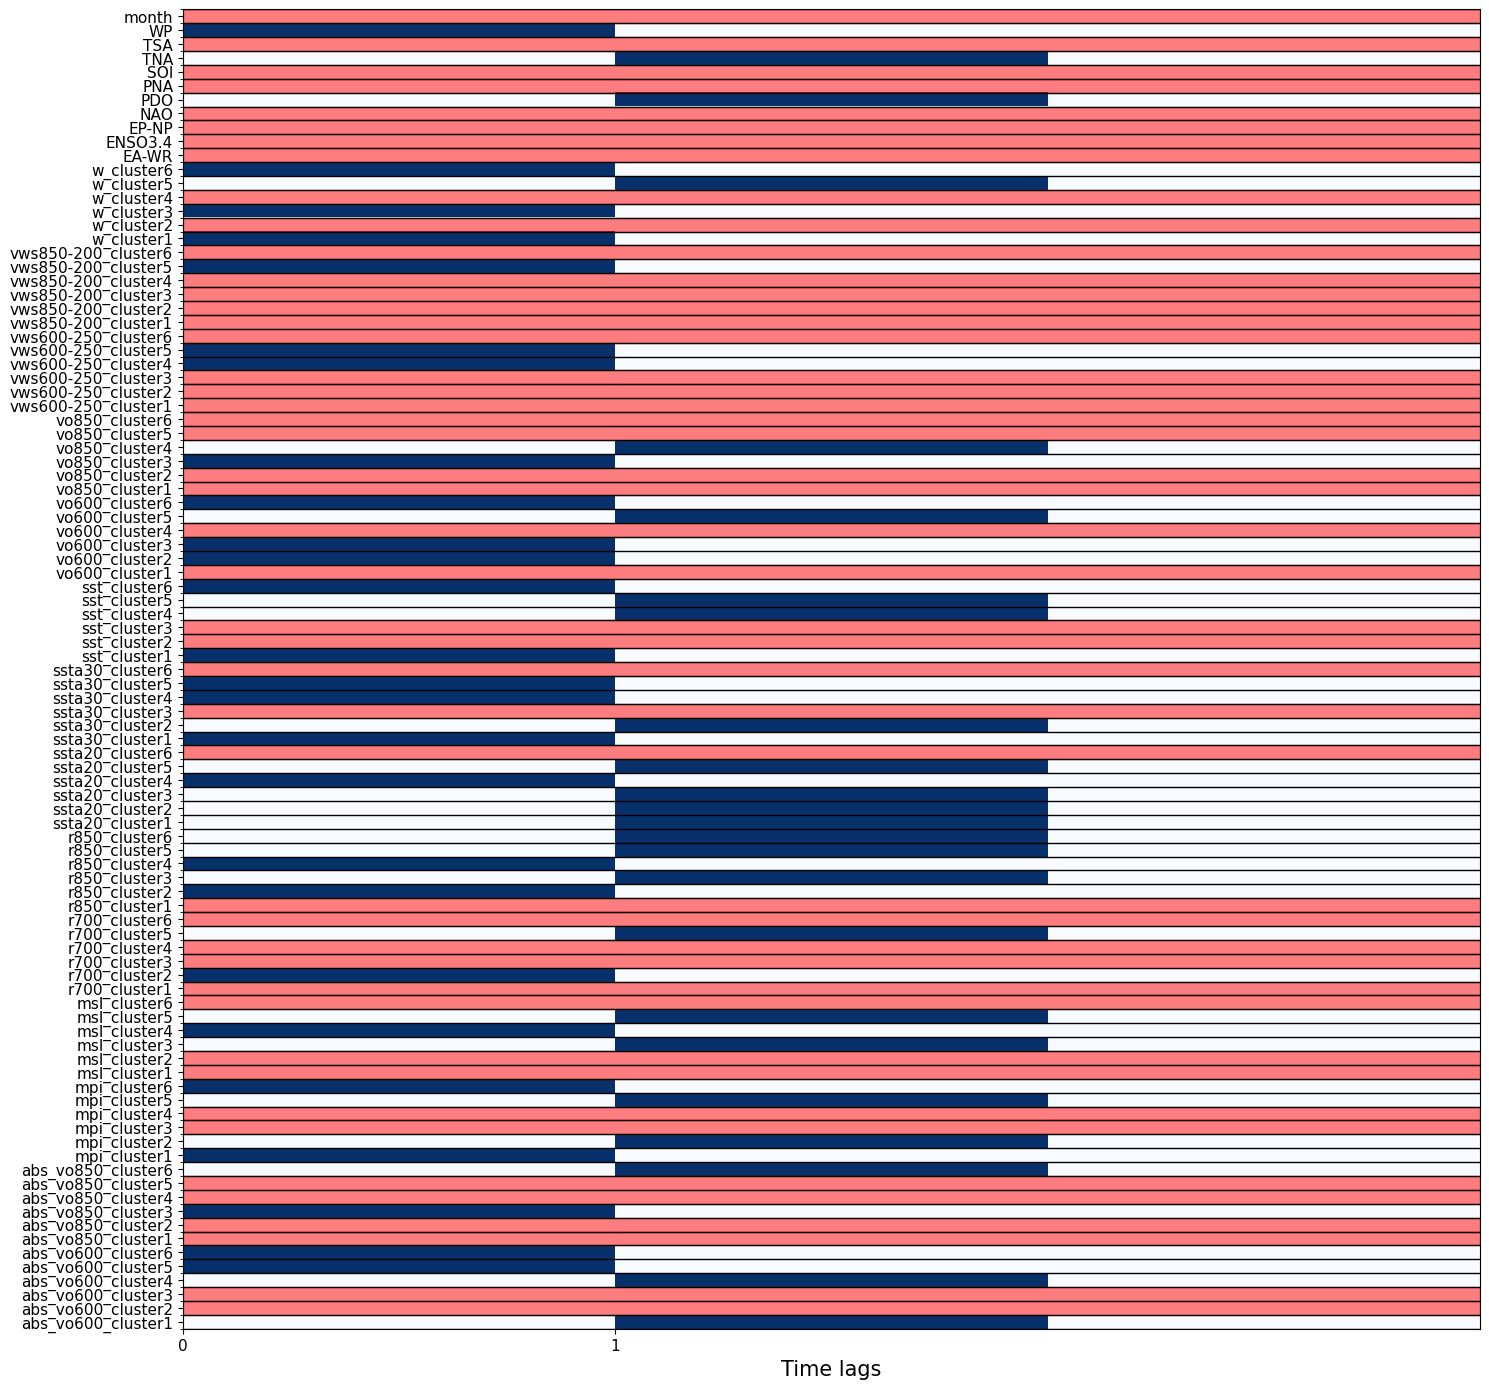

In [29]:
fig_trial = plot_board_transposed(board_best, column_names, feat_sel)